In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from zipfile import ZipFile
import zipfile
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import msgpack
import os
import io
import PIL.Image as Image
import seaborn as sns
import geopandas as gpd
from pathlib import Path

# Load and plot the image

In [4]:
def get_image(record):
        return Image.open(BytesIO(record["image"]))

path_archive =Path('../00-data/raw_data/archive.zip')
path_data_csv =Path('../00-data')

### Load the data from CSV

In [ ]:
def load_data_csv(path_data_csv:str,limit:int) ->None:
    path_data_csv =Path('../00-data/data_csv')
    for i in range(limit):
        if i ==0:
            df_meta=pd.read_csv(os.path.join(path_data_csv,f'meta_shard_{i}.csv'))
        else:
            df_temp=pd.read_csv(os.path.join(path_data_csv,f'meta_shard_{i}.csv'))
            df_meta=pd.concat([df_meta,df_temp])
    return 

### Plot random data from the csv

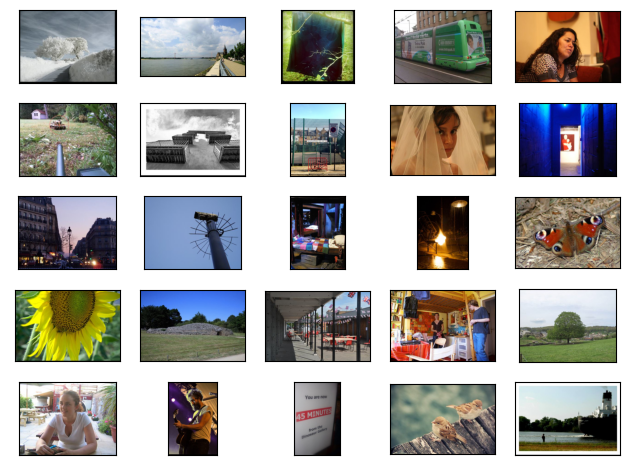

In [6]:
def plot_25_pics(path_data_csv:str) ->None:
    i=np.random.randint(0,141)
    df_meta=pd.read_csv(f'{path_data_csv}/meta_shard_{i}.csv')

    if len(df_meta)>25:
        min_index = np.random.randint(25,len(df_meta)-26)
        for j in range(25):
            plt.subplot(5, 5, j + 1)

            # Display each image with a title, which we grab from the dataset
            plt.imshow(Image.open(BytesIO(bytes.fromhex(df_meta.data[min_index+j]))))
            

            # Remove plot ticks
            plt.xticks(())
            plt.yticks(())

        plt.tight_layout()
    return

## Extract the first pictures

In [40]:
def extract_first_250_pics(path_data_csv:str) ->None:
    df_meta=pd.read_csv(f'{path_data_csv}/meta_shard_0.csv')
    for i in range(250):
        image =Image.open(BytesIO(bytes.fromhex(df_meta.data[i])))
        image.save(f'{path_data_csv}/../pictures/pict{i}.png')
    return

## Extract all the pictures

In [ ]:
def extract_all_pics(path_data_csv:str) ->None:
    for j in range (142):
        df_meta=pd.read_csv(f'{path_data_csv}/meta_shard_0.csv')
        for i in range(len(df_meta)):
            image =Image.open(BytesIO(bytes.fromhex(df_meta.data[i])))
            image.save(f'{path_data_csv}/../pictures/pict{i}.png')
            if i==len(df_meta):
                print(f'All pics from file {j} have been extracted')
    return None

# Load the data located in France into CSV

In [31]:
with zipfile.ZipFile(path_archive, mode="r") as zip_folder:
    zip_folder.printdir()

File Name                                             Modified             Size
shards/shard_0.msg                             2022-07-27 14:55:02    725006888
shards/shard_1.msg                             2022-07-27 15:03:40    724916138
shards/shard_10.msg                            2022-07-27 15:04:38    726278181
shards/shard_100.msg                           2022-07-27 15:06:06    723477871
shards/shard_101.msg                           2022-07-27 15:07:16    721893436
shards/shard_102.msg                           2022-07-27 15:08:24    723789063
shards/shard_103.msg                           2022-07-27 15:09:34    724658390
shards/shard_104.msg                           2022-07-27 15:11:00    723856059
shards/shard_105.msg                           2022-07-27 15:12:58    723033383
shards/shard_106.msg                           2022-07-27 15:14:14    722443434
shards/shard_107.msg                           2022-07-27 15:15:24    724186635
shards/shard_108.msg                    

In [10]:
def load_all_data_from_archive(path_to_archive:str) ->None:
    df_meta=pd.DataFrame(columns=['img','lat','lon','data'],index=range(0))
    path_to_archive = Path(path_to_archive)
    with zipfile.ZipFile(path_to_archive, mode="r") as zip_folder:
        for i in range(0,142):
            with zip_folder.open(f'shards/shard_{i}.msg',mode='r') as infile:
                for record in msgpack.Unpacker(infile, raw=False):
                    img_name = str(record["id"]).replace('/','_')
                    lat_zone = round(float(record["latitude"]),8) 
                    lon_zone = round(float(record["longitude"]),8)
                    data_img = record["image"].hex()
                    if lon_zone >-5 and lon_zone<10 and lat_zone>42 and lat_zone<52:
                        a ={'img':[img_name],'lat':[lat_zone],'lon':[lon_zone],'data':[data_img]}
                        a=pd.DataFrame.from_dict(a) 
                        df_meta = pd.concat((df_meta,a))
                df_meta.dropna(inplace=True)
                df_meta.to_csv(f'../00-data/data_csv/meta_shard_{i}.csv',index=False,header=True)
                df_meta=pd.DataFrame(columns=['img','lat','lon','data'],index=range(0))
    return

### Load the data extracted formerly

In [173]:
def load_csv(path_to_csv:str) ->pd.DataFrame:
    path_to_csv=Path(path_to_csv)
    for i in range(142):
        if i ==0:
            df_meta=pd.read_csv(f'{path_to_csv}/meta_shard_{i}.csv')
        else:
            df_temp=pd.read_csv(f'{path_to_csv}/meta_shard_{i}.csv')
            df_meta=pd.concat([df_meta,df_temp])
    return df_meta

# Map the location of the data gathered

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


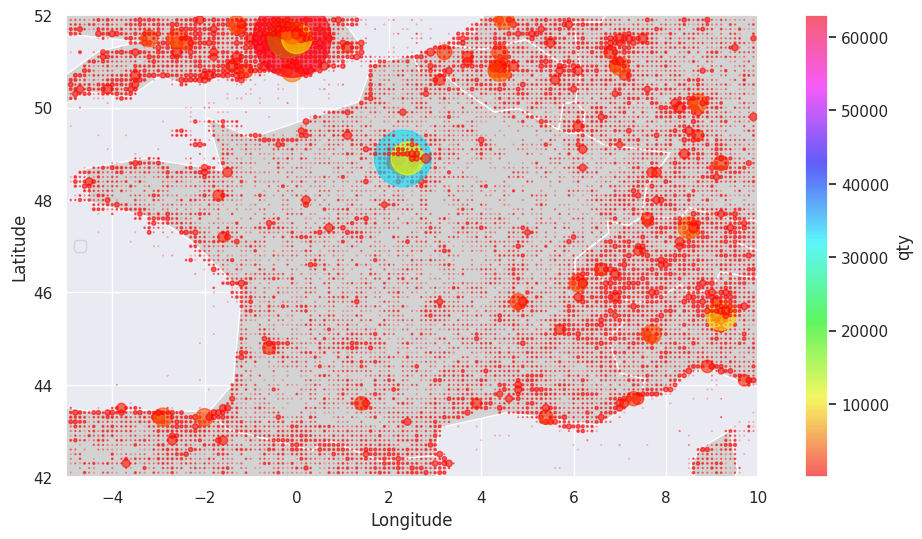

In [180]:
def plot_worldmap(df_meta:pd.DataFrame) ->None:

    df_meta['qty']=1
    df_meta_gpd=df_meta.groupby(by=['lat','lon']).sum()
    df_meta_gpd.reset_index(inplace=True)
    worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    fig, ax = plt.subplots(figsize=(12,6))
    worldmap.plot(color="lightgrey", ax=ax)

    x=df_meta_gpd.lon
    y=df_meta_gpd.lat
    z=df_meta_gpd.qty

    plt.scatter(x,y,s=z/20, c=z, alpha=0.6,cmap='hsv')
    plt.colorbar(label='qty')
    plt.legend()
    # Creating axis limits and title
    plt.xlim([-5, 10])
    plt.ylim([42, 52])

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    
    return